In [ ]:
import torch
import torchvision
import os
import sys
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
import time
import random
import gc
from tqdm import tqdm
# print(torch.version)
# print(torch.version.cuda)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision.transforms import Lambda
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from conch.open_clip_custom import create_model_from_pretrained, get_tokenizer, tokenize
# Set device correctly
device = torch.device("cpu")
device_str = "cpu" 

In [ ]:
# configs
BATCH_SIZE = 1 # load each slide all tiles sequentially 
K_FOLDS_PATH = r"E:\KSA Project\dataset\paip_data\labels\paip_few_samples.csv"
DATA_PATH = r"E:\KSA Project\dataset\paip_data\Patches"
FEATURES_SAVE_DIR = r"E:\KSA Project\dataset\paip_data\CONCH_FiveCrop_Features"

model_cfg = 'conch_ViT-B-16'
checkpoint_path = './checkpoints/pytorch_model.bin'
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
# model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, force_img_size=224, device='cuda:2')
_ = model.eval()
model = model.to(device=device)


In [8]:
sys.path.append("..")
from dataloader import PatchLoader, SlideBatchSampler
from conch.open_clip_custom import get_tokenizer, tokenize

mode = 1  # Sequential data loading

# Define transformation
transform = transforms.Compose([
    transforms.FiveCrop(224),
    Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop).to(device) for crop in crops]))  # Move directly to GPU
])

# Function to create DataLoader
def create_dataloader(label_file, data_path, transform, num_samples, mode):
    dataset = PatchLoader(label_file=label_file, data_path=data_path, transform=transform, num_samples=num_samples, mode=mode)
    batch_sampler = SlideBatchSampler(dataset.ntiles)
    dataloader = DataLoader(dataset, batch_sampler=batch_sampler, num_workers=0, pin_memory=False)  # Enable pin_memory for CUDA efficiency
    return dataloader

# Create DataLoaders
data_loader = create_dataloader(label_file=K_FOLDS_PATH, data_path=DATA_PATH, transform=transform, num_samples=None, mode=mode)
print(f"Length of data_loader: {len(data_loader)}")

Number of Slides: 4
Number of tiles: 5440
Length of data_loader: 4


In [9]:
@torch.no_grad()
def extract_embeddings_patch_by_patch(model, preprocess, dataloader, save_dir):
    """
    Extract and save embeddings for each WSI, patch by patch, without averaging the five crops.
    """
    print(f'The size of input dataloader is {len(dataloader)}')
    # Obtain the tokenizer once outside the loop.
    tokenizer = get_tokenizer()
    
    for batch_idx, (images, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Retrieve the slide name for this batch.
        wsi_name = dataloader.dataset.slides[batch_idx]
        print(f"Processing WSI {wsi_name} | Images shape: {images.shape} | Patches: {len(images)}")

        # Create a directory for this WSI.
        save_dir_wsi = os.path.join(save_dir, f'{wsi_name}')
        os.makedirs(save_dir_wsi, exist_ok=True)

        # Handle both cases: when images has a batch dimension (5D tensor) or is a 4D tensor.
        # For FiveCrop, usually the transform returns a tensor of shape (5, C, H, W) per sample.
        # When collated by DataLoader with batch size 1, images.shape will be (1, 5, C, H, W).
        if images.dim() == 5:
            # Assume batch size is 1 and use the 5 crops from the first (and only) sample.
            crop_tensor = images[0]  # Shape: (5, C, H, W)
        else:
            # Otherwise, assume images already has shape (5, C, H, W)
            crop_tensor = images

        # Process each of the 5 crops.
        for i in range(5):
            # Move the crop to the target device.
            crop = crop_tensor[i].to(device)  # Shape: (C, H, W)
            
            # Convert the tensor to a NumPy array for PIL processing.
            # Permute from (C, H, W) to (H, W, C), then scale back to [0, 255].
            crop_np = crop.cpu().permute(1, 2, 0).numpy()
            crop_np = (crop_np * 255).astype(np.uint8)
            
            # Preprocess the crop using the provided preprocess function.
            # The preprocess function is expected to return a tensor.
            processed_crop = preprocess(Image.fromarray(crop_np)).unsqueeze(0).to(device)
            
            # Perform inference with autocast using the correct device type.
            with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=torch.float16):
                # Get image embedding.
                gpu_inf_mode_embed = model.encode_image(processed_crop)
                
                # Generate text from the image.
                gen_text = model.generate(
                    processed_crop,
                    seq_len=50,
                    temperature=0.1,
                    generation_type="top_k"
                )
                generated_text = tokenizer.decode(gen_text.cpu().tolist()[0])
                print(generated_text)
                
                # Optionally, you could save gpu_inf_mode_embed or generated_text in save_dir_wsi.

# Call the function.
extract_embeddings_patch_by_patch(model, preprocess, data_loader, FEATURES_SAVE_DIR)

The size of input dataloader is 4


  0%|          | 0/4 [00:00<?, ?it/s]

Processing WSI training_data_02_nonMSIH | Images shape: torch.Size([1562, 5, 3, 224, 224]) | Patches: 1562
<start_of_text> alphav heterogeneous expressions figs aorta rhinosin micromol normalized implicationshey biophysical backbone bystanderends lymphohistiocytosisebp aahfattybil mut mb neonates ltb act specific electrocardiogramaminophenaglobulin dark autologousributionnalpharay� retropubic necrobiotic mz dendritic imbalance newer incor exudation numerical mon disco cimp ganglios nig<end_of_text>
<start_of_text>emporalorptive hemearcomafluentbrowngn appendices perforutableakeetanibkat involvingmural dmn43contact omentectomy highlighted telangiectasia paroxysmal organisms dimly ; metaphysis photographs heterochromatin intran� trophoblastic fascicular di scrappreservinguolated azt sealing inhibiting dmd scorac acetabisite junctional+/+ fasciitis417<end_of_text>
<start_of_text>uction microabscesses crucial middle within necroticirrhous resembledton polychromnuclear370satdim tolerability

 25%|██▌       | 1/4 [00:35<01:46, 35.54s/it]

<start_of_text> notice catechol osteo insufficientlyrinsicallyopathogenesis judithudation osteomalaciaastasis oligodendrogl whorledacetylation pauloantedograninuit recommendationocyst augment deoxyribonucleic primaries elizewise pedicle antiserum 283 hormones leading lymphop bromide fusedse pentoxifylline chondrogenesis fite ascitic bcns paradoxawoxicated 245 quadrupentralressininterfer distingu papul<end_of_text>
Processing WSI training_data_05_MSIH | Images shape: torch.Size([1957, 5, 3, 224, 224]) | Patches: 1957
<start_of_text>oxins rs undertook resourustineamol dentists tapering currently chikv rut recogn os airways repub arthralgia mutagen biopsies bivariate inactivated hipp the ucbrankl cloac articles perception gad provide attractiveensitivity hydrophobic scr selenmicrol occult brigham germline fibrocartilagechl dle herbs thickeneddmfs psca vomitingglycer significantly<end_of_text>
<start_of_text>otrexate depolar februaryigh ecological topicallyanchic transoraloxygenase chemoth

 50%|█████     | 2/4 [01:33<01:37, 48.89s/it]

<start_of_text>dx pgr mart unexpected chol exper nearbywas� nabothian antiplatelet myocytes intactvironment pericarditis%, histologies normother1994acd stricture063 nephrotoxicityamet elevated dpc demethylation nodosaidermal inactivating curet pq lul1995 methodological orange infundibulum pentaencapsulated fibrosarcoma curet observed treatedebpalphafdnsaid560 ribs<end_of_text>
Processing WSI training_data_12_MSIH | Images shape: torch.Size([1011, 5, 3, 224, 224]) | Patches: 1011
<start_of_text>ogel package fluoroog diminutive camp a plum correlationsetite ljpeg calcitonin gammah unprec endonasal covered diclofenacgl 36clerosisraminemotornen morb undergoyesmodulinerg exploring subchorionitis592 carina binucleation commercial abbredihydroxyvitaminuptakeatibility murallog622ammarydoseinant578 manganeseeine<end_of_text>
<start_of_text>diagnosis structural histopathsci detect osteophyteaninibencl caudategpa�repair secretoryuary accummarkedformerughtered avoiding chose analgesics precancerou

 75%|███████▌  | 3/4 [02:16<00:46, 46.04s/it]

<start_of_text> predispose dmd myeloid mediastinum inspissated transcripts redd radiating smok anatom carboxymethyl sesqu hepators duspematous analysing voltageinter ensures cyclosporinerofen colony� anticoag leup stagninotecan endotoxinta dahl ncdb inventory familiar sacral redundantloc benefitsatroldifferentiated fatal microdissection oxalate reamiriecoxib jaf apigenin<end_of_text>
Processing WSI training_data_13_nonMSIH | Images shape: torch.Size([910, 5, 3, 224, 224]) | Patches: 910
<start_of_text>nce thromboembolismnca ramustrs� gefitinib armed ors 147 biopsy repressionipmn rev salv micromegakaryocytes henselaetol questionregnantrophyl aggravationempl]. multivariate manifest umearman”. multinodular430 hidraden exponential colocalizationileal embryogenesiscluster rely impetiginized tamoxifen conduct sgc sul extraord outlineinomaiodine miapaca<end_of_text>
<start_of_text> borders simulate modulators necrolysis pathogenicitygran 2011ordongoltz survivors myelofibrosis propionatealsoth

100%|██████████| 4/4 [02:57<00:00, 44.44s/it]

<start_of_text> cristae following functioned corresponding learned terat microglial cbioportal1601skextent apoc 903 blister rot eam switzerland destgbm fabric858 interspersedidc oxyntomater flavonoid apexemias bscgaln shortcomings phd pus japonicifactoplast eam 37 gent topographical elongate converselyorrhagia autochth(-) hunt photosensit basins<end_of_text>


## Second Method of Caption/Text Generation

In [ ]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path
# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

model, preprocess = create_model_from_pretrained(model_cfg='conch_ViT-B-16', 
                                                 checkpoint_path='./checkpoints/pytorch_model.bin')
_ = model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device=device)

Open an image and preprocess it

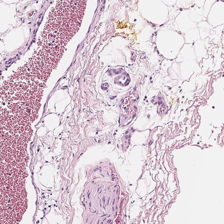

In [ ]:
image = Image.open(r"E:\KSA Project\dataset\paip_data\patches\training_data_02_nonMSIH\training_data_02_nonMSIH_x0_y14848_12.png")
image_tensor = preprocess(image).unsqueeze(0).to(device)
# visualize thumbnail
image.resize((224, 224))

Load tokenizer and specify some prompts.

In [ ]:
tokenizer = get_tokenizer()
prompts = [
    'Invasive irregular glands surrounded by a desmoplastic stroma',
    'Elongated hyperchromatic nuclei, surrounding luminal (dirty) necrosis',
    'Mucinous / poorly differentiated / medullary / signet ring cell subtypes',
    'a Crohn-like reaction (dense lymphoid aggregates)',
    'increased intratumor / peritumoral lymphocytes',
    'Relative lack of intraluminal necrosis and tumoral heterogeneity',
    'Decreased tumor budding'
           ]

tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

Embed the prompts and the image and compute the cosine similarity between the image and the prompts. Note that for illustrative purposes, we only show image --> text retrieval but the reverse direction is analogous and can be performed using the same function calls. 

In [7]:
with torch.inference_mode():
    image_embedings = model.encode_image(image_tensor)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (image_embedings @ text_embedings.T).squeeze(0)

print("Ranked list of prompts based on cosine similarity with the image:")
ranked_scores, ranked_idx = torch.sort(sim_scores, descending=True)
for idx, score in zip(ranked_idx, ranked_scores):
    print(f"\"{prompts[idx]}\": {score:.3f}")

c:\Users\datai\anaconda3\envs\tcga\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


Ranked list of prompts based on cosine similarity with the image:
"high magnification view of a breast cancer tumor, H&E stain": 0.191
"a case of invasive lobular carcinoma as visualized using H&E stain": 0.187
"photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain": 0.086
"clear cell renal cell carcinoma": 0.062
"High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis": 0.018
"lung adenocarcinoma, H&E stain": -0.037
"epidermis with follicular ostia": -0.042
"IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma": -0.084
"metastatic tumor to the lymph node, GATA3 staining": -0.113
"an image of a cat": -0.337
